In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrnd
import jax.scipy.stats as stats

from blackjax.slice_kernels import elliptical_slice, mvt_elliptical_slice, atransp_elliptical_slice

from numpyro.diagnostics import effective_sample_size as ess, print_summary

import optax
from jax.example_libraries import stax
from jax.experimental.host_callback import id_print

import matplotlib.pyplot as plt
import arviz as az

In [2]:
from jax.config import config
config.update("jax_debug_nans", True)

In [3]:
def rbf_kernel(x, y, length, scale):
#     dot_diff = jnp.dot(x-y, x-y)
#     dot_diff = jnp.sum((x - y)**2)
    dot_diff = jnp.dot(x, x) + jnp.dot(y, y) - 2 * jnp.dot(x, y)
    return scale**2 * jnp.exp(-.5 * dot_diff / length**2)

In [4]:
def inference_loop0(rng, init_state, kernel, n_iter):
    keys = jrnd.split(rng, n_iter)
    def step(state, key):
        state, info = kernel(key, state)
        return state, (state, info)
    _, (states, info) = jax.lax.scan(step, init_state, keys)
    return states, info

In [5]:
def inference_loop(rng, init_state, kernel, n_iter, param):
    keys = jrnd.split(rng, n_iter)
    def step(state, key):
        state, info = kernel(key, state, param)
        return state, (state, info)
    _, (states, info) = jax.lax.scan(step, init_state, keys)
    return states, info

# Gaussian regression

In [29]:
n, d = 10, 2
length, scale = 1., 1.
y_sd = .3

#fake data
rng = jrnd.PRNGKey(10)
kX, kf, ky = jrnd.split(rng, 3)
X = jrnd.uniform(kX, shape=(n, d))
# X = jrnd.normal(kX, shape=(n, d))
Sigma = jax.vmap(lambda x: jax.vmap(lambda y: rbf_kernel(x, y, length, scale))(X))(X) + 1e-3 * jnp.eye(n)
invSigma = jnp.linalg.inv(Sigma)
f = jrnd.multivariate_normal(kf, jnp.zeros(n), Sigma)
y = f + jrnd.normal(ky, shape=(n,)) * y_sd

#actual conjugate results
posterior_cov = jnp.linalg.inv(invSigma + 1 / y_sd**2 * jnp.eye(n))
posterior_mean = jnp.dot(posterior_cov, y) * 1 / y_sd**2 

In [57]:
optim = optax.adam(1e-3)
non_lin = stax.Tanh
# non_lin = stax.Elu
n_hidden = [n] * 4
n_atoms = 10
n_flow = 2

n_epochs = 5
batch_size = 3000
n_warm = n_epochs * batch_size

vi_iter = 1000
pre_iter = n_epochs * vi_iter
# n_warm = vi_iter #too much warm up not good for nuts, it semms

n_iter = 1000
n_chain = 4

In [31]:
#sample using elliptical slice sampling
loglikelihood_fn = lambda f: -.5 * jnp.dot(y - f, y - f) / y_sd**2
init, kernel = elliptical_slice(loglikelihood_fn, Sigma)
ksam, kf = jrnd.split(jrnd.PRNGKey(0))

def one_ess_chain(ksam, init_x):
    init_state = init(init_x)
    warm_states, warm_info = inference_loop0(jrnd.PRNGKey(0), init_state, kernel, n_warm)
    state = jax.tree_util.tree_map(lambda x: x[-1], warm_states)
    states, info = inference_loop0(ksam, state, kernel, n_iter)
    return states.position, info.subiter.mean(), (warm_states, warm_info)

init_fs = jrnd.normal(kf, shape=(n_chain, n))
ksam = jrnd.split(ksam, n_chain)
samples_ess, subiter_ess, diagnose_ess = jax.vmap(one_ess_chain)(ksam, init_fs)
print_summary(samples_ess)
print("Subiter", subiter_ess)
print("MSE mean", jax.vmap(lambda s: jnp.sum((s.mean(axis=0) - posterior_mean)**2))(samples_ess))
print("MSE cov", jax.vmap(lambda s: jnp.sum((jnp.cov(s, rowvar=False) - posterior_cov)**2))(samples_ess))


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      1.51      0.17      1.51      1.23      1.78    308.20      1.01
Param:0[1]      1.55      0.16      1.55      1.28      1.80    208.98      1.04
Param:0[2]      1.35      0.20      1.35      1.02      1.68    258.52      1.01
Param:0[3]      1.76      0.14      1.75      1.54      2.00    351.02      1.01
Param:0[4]      1.51      0.15      1.52      1.30      1.77    223.73      1.03
Param:0[5]      1.73      0.16      1.73      1.47      1.99    369.71      1.01
Param:0[6]      1.38      0.15      1.38      1.13      1.62    433.98      1.00
Param:0[7]      1.80      0.18      1.80      1.50      2.08    244.65      1.02
Param:0[8]      1.07      0.23      1.07      0.71      1.46    372.44      1.00
Param:0[9]      1.65      0.12      1.65      1.45      1.83    514.11      1.00

Subiter [5.452     5.57      5.7840004 5.478    ]
MSE mean [0.00281289 0.010721   0.00956431 0.00158111]
MS

In [59]:
logprob_fn = lambda f: -.5 * jnp.dot(y - f, y - f) / y_sd**2 -.5 * jnp.dot(jnp.dot(f, invSigma), f)
# logprob_fn = lambda f: -.5 * jnp.dot(y - f, y - f) / y_sd**2 + stats.multivariate_normal.logpdf(f, jnp.zeros(n), Sigma)
atess, warm_fn = atransp_elliptical_slice(logprob_fn, optim, n, n_flow, n_hidden, non_lin)
ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)

def one_chain(ksam, init_x):
    kinit, kwarm, ksam = jrnd.split(ksam, 3)
    state, param, err = atess.init(kinit, init_x, n_atoms, vi_iter)
    (state, param), error = warm_fn(kwarm, state, param, n_epochs, batch_size, vi_iter)
    states, info = inference_loop(ksam, state, atess.step, n_iter, param)
    return states.position, info.subiter.mean(), (err, param, error)

init_fs = jrnd.normal(kf, shape=(n_chain, n))
ksam = jrnd.split(ksam, n_chain)
samples, subiter, diagnose = jax.vmap(one_chain)(ksam, init_fs)
print_summary(samples)
print("Subiter", subiter)
print("MSE mean", jax.vmap(lambda s: jnp.sum((s.mean(axis=0) - posterior_mean)**2))(samples))
print("MSE cov", jax.vmap(lambda s: jnp.sum((jnp.cov(s, rowvar=False) - posterior_cov)**2))(samples))


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      1.51      0.16      1.51      1.27      1.80   2308.41      1.00
Param:0[1]      1.53      0.16      1.52      1.28      1.78   2227.27      1.00
Param:0[2]      1.33      0.18      1.33      1.03      1.62   2035.25      1.00
Param:0[3]      1.76      0.12      1.76      1.56      1.97   2168.92      1.00
Param:0[4]      1.50      0.14      1.50      1.28      1.73   2271.72      1.00
Param:0[5]      1.73      0.15      1.73      1.48      1.97   2238.48      1.00
Param:0[6]      1.38      0.15      1.38      1.15      1.63   2146.75      1.00
Param:0[7]      1.81      0.15      1.81      1.58      2.08   2183.54      1.00
Param:0[8]      1.07      0.22      1.07      0.70      1.44   2046.73      1.00
Param:0[9]      1.65      0.10      1.65      1.49      1.83   2295.14      1.00

Subiter [1.728     1.7540001 1.7160001 1.6680001]
MSE mean [0.00086833 0.00194247 0.00090079 0.00108232]
MS

# Log Gaussian Cox Process

In [6]:
import pandas as pd
mining = pd.read_csv("mining_disasters.csv")

bin_range = 50/365

bins = jnp.arange(mining.date.values[0], mining.date.values[-1]+bin_range, bin_range)[1:]
counts = jax.vmap(lambda date: jnp.where((bins-date < bin_range) * (bins-date > 0), 1, 0))(mining.date.values).sum(axis=0)
bins *= 365
# bins = (bins - bins.mean()) / bins.std()

In [7]:
length, scale = 13516, 1
mean = jnp.log(191/811)
# length, scale = (bins.max() - bins.min()) / 3, 1
n = counts.shape[0]

day_diff = jnp.abs(bins[:, None] - bins)
Sigma = scale**2 * jnp.exp(-.5 * day_diff**2 / length**2) + 1e-3 * jnp.eye(n)
f = jrnd.multivariate_normal(jrnd.PRNGKey(1), jnp.zeros(n), Sigma)

In [10]:
optim = optax.adam(1e-4)
non_lin = stax.Tanh
# non_lin = stax.Elu
n_hidden = [n] * 2
n_atoms = 100
n_flow = 2

n_epochs = 1
batch_size = 100
n_warm = n_epochs * batch_size

vi_iter = 100
pre_iter = n_epochs * vi_iter
# n_warm = vi_iter #too much warm up not good for nuts, it semms

n_iter = 1000
n_chain = 4


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  Param:0[0]      0.61      0.21      0.62      0.24      0.93    118.53      1.03
  Param:0[1]      0.62      0.21      0.62      0.26      0.96    104.07      1.04
  Param:0[2]      0.62      0.21      0.63      0.29      0.96     98.62      1.04
  Param:0[3]      0.63      0.20      0.64      0.27      0.95    112.27      1.03
  Param:0[4]      0.63      0.21      0.63      0.25      0.94    111.48      1.03
  Param:0[5]      0.62      0.20      0.63      0.28      0.95    108.80      1.05
  Param:0[6]      0.62      0.20      0.62      0.29      0.96    107.79      1.04
  Param:0[7]      0.62      0.20      0.62      0.25      0.92    106.39      1.03
  Param:0[8]      0.64      0.20      0.65      0.29      0.95    106.13      1.04
  Param:0[9]      0.63      0.20      0.64      0.32      0.96    109.64      1.05
 Param:0[10]      0.64      0.19      0.64      0.30      0.93    141.60      1.03
 Pa

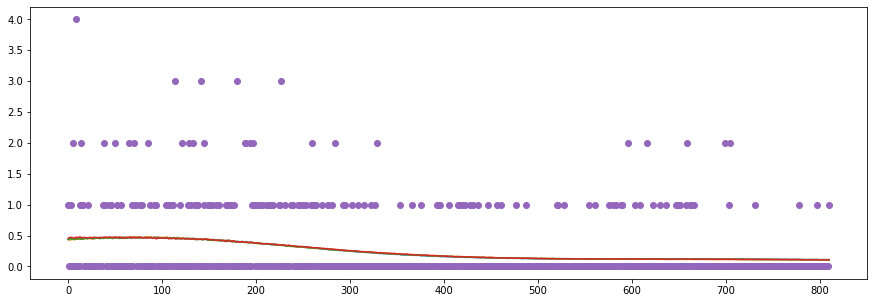

In [9]:
#sample using elliptical slice sampling
def loglikelihood_fn(f):
    loglamda = f + mean
    factorials = jnp.where(counts < 2, 1, jnp.where(counts < 3, 2, jnp.where(counts < 4, 6, 24)))
    return jnp.sum(counts * loglamda - jnp.exp(loglamda) - jnp.log(factorials))
init, kernel = elliptical_slice(loglikelihood_fn, Sigma)
ksam, kf = jrnd.split(jrnd.PRNGKey(0))

def one_ess_chain(ksam, init_x):
    init_state = init(init_x)
    warm_states, warm_info = inference_loop0(jrnd.PRNGKey(0), init_state, kernel, n_warm)
    state = jax.tree_util.tree_map(lambda x: x[-1], warm_states)
    states, info = inference_loop0(ksam, state, kernel, n_iter)
    return states.position, info.subiter.mean(), (warm_states, warm_info)

init_fs = jrnd.normal(kf, shape=(n_chain, n))
ksam = jrnd.split(ksam, n_chain)
samples_ess, subiter_ess, diagnose_ess = jax.vmap(one_ess_chain)(ksam, init_fs)
print_summary(samples_ess)
print("Subiter", subiter_ess)
lamdas = jnp.exp(samples_ess + mean).mean(axis=1)
plt.figure(figsize=(15, 5))
plt.plot(lamdas.T)
plt.plot(counts, 'o')
plt.show()

In [ ]:
def logprob_fn(f):
    loglamda = f + mean
    factorials = jnp.where(counts < 2, 1, jnp.where(counts < 3, 2, jnp.where(counts < 4, 6, 24)))
    return (
        jnp.sum(counts * loglamda - jnp.exp(loglamda) - jnp.log(factorials)) +
        stats.multivariate_normal.logpdf(f, jnp.zeros(n), Sigma)
    )
atess, warm_fn = atransp_elliptical_slice(logprob_fn, optim, n, n_flow, n_hidden, non_lin)
ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)

def one_chain(ksam, init_x):
    kinit, kwarm, ksam = jrnd.split(ksam, 3)
    state, param, err = atess.init(kinit, init_x, n_atoms, vi_iter)
    (state, param), error = warm_fn(kwarm, state, param, n_epochs, batch_size, vi_iter)
    states, info = inference_loop(ksam, state, atess.step, n_iter, param)
    return states.position, info.subiter.mean(), (err, param, error)

init_fs = jrnd.normal(kf, shape=(n_chain, n))
ksam = jrnd.split(ksam, n_chain)
samples, subiter, diagnose = jax.vmap(one_chain)(ksam, init_fs)
print_summary(samples)
print("Subiter", subiter)
lamdas = jnp.exp(samples + mean).mean(axis=1)
plt.figure(figsize=(15, 5))
plt.plot(lamdas.T)
plt.plot(counts, 'o')
plt.show()

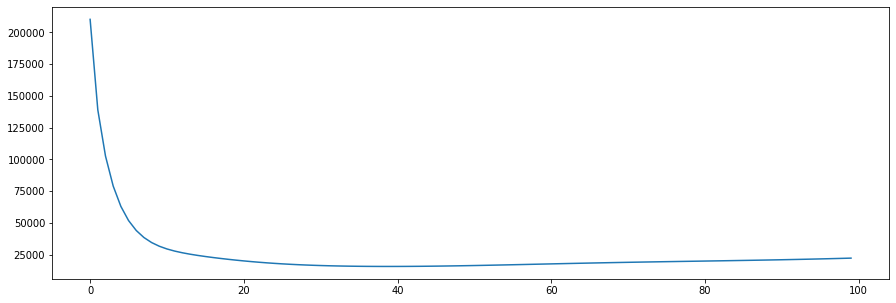

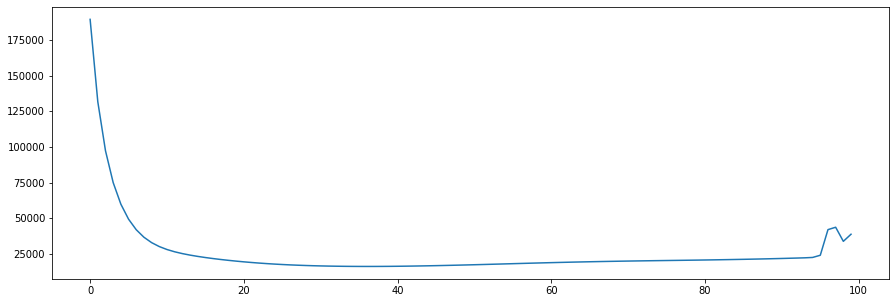

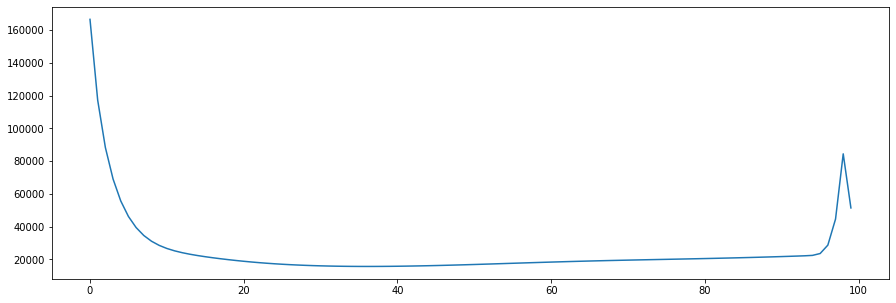

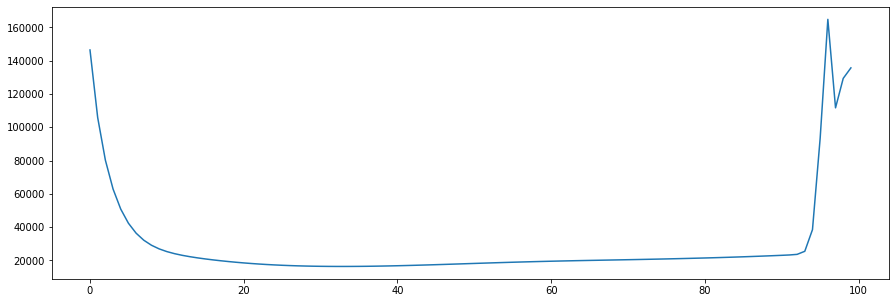

In [23]:
for i in range(n_chain):
    plt.figure(figsize=(15, 5))
    plt.plot(diagnose[2][i].T)
    plt.show()

array([[<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>]], dtype=object)

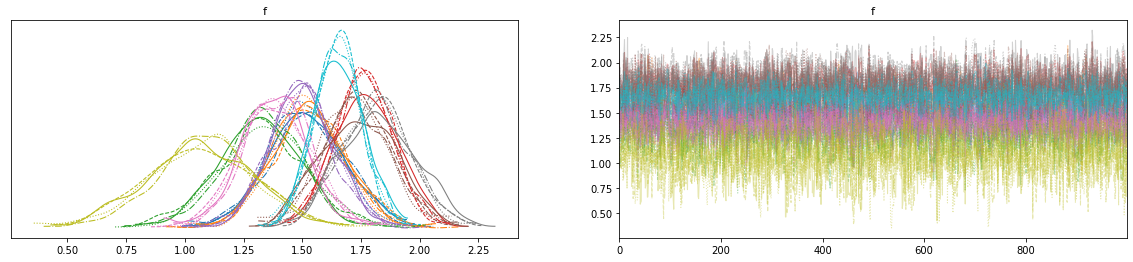

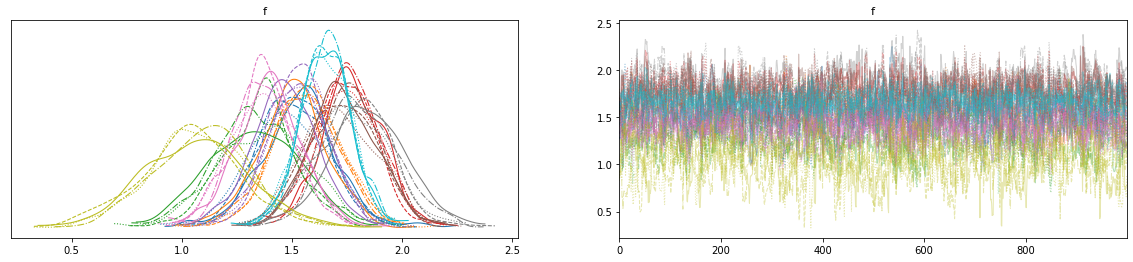

In [61]:
inf_samples = az.from_dict({'f': samples})
inf_ess_samples = az.from_dict({'f': samples_ess})
az.plot_trace(inf_samples, figsize=(20, 4))
az.plot_trace(inf_ess_samples, figsize=(20, 4))